<a href="https://colab.research.google.com/github/hdas25/Deep-Learning-Assignments/blob/main/Assignment_1_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🔹 1. Import Libraries and Setup

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


🔹 2. Load and Visualize MNIST Data

Sample training images:


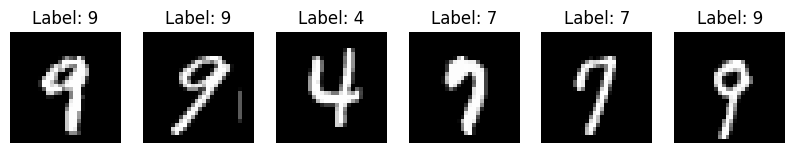

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

# Load training and test data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Data loaders
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Visualize samples
def visualize_samples(loader, num_samples=6):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    fig = plt.figure(figsize=(10, 4))
    for idx in range(num_samples):
        ax = fig.add_subplot(1, num_samples, idx+1)
        ax.imshow(images[idx].squeeze(), cmap='gray')
        ax.set_title(f"Label: {labels[idx]}")
        ax.axis('off')
    plt.show()

print("Sample training images:")
visualize_samples(train_loader)


🔹 3. Multi-Layer Perceptron (MLP)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

mlp_model = MLP().to(device)
print("MLP Model Architecture:")
print(mlp_model)


MLP Model Architecture:
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


🔹 4. Loss, Optimizer, Evaluation Function

In [ ]:
# Loss and optimizer
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Evaluation function
def evaluate(model, criterion, test_loader):
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(test_loader.dataset), 100 * correct / total


🔹 5. Train MLP

In [ ]:
def train_mlp(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        test_loss, test_acc = evaluate(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    return train_losses, test_losses, test_accuracies

# Train MLP
print("\nTraining MLP...")
mlp_train_losses, mlp_test_losses, mlp_test_accuracies = train_mlp(
    mlp_model, mlp_optimizer, mlp_criterion, train_loader, test_loader, epochs=10
)



Training MLP...
Epoch [1/10] Train Loss: 0.2345, Test Loss: 0.1076, Accuracy: 96.61%
Epoch [2/10] Train Loss: 0.1110, Test Loss: 0.0839, Accuracy: 97.36%
Epoch [3/10] Train Loss: 0.0850, Test Loss: 0.0787, Accuracy: 97.66%
Epoch [4/10] Train Loss: 0.0730, Test Loss: 0.0748, Accuracy: 97.78%
Epoch [5/10] Train Loss: 0.0631, Test Loss: 0.0700, Accuracy: 97.93%
Epoch [6/10] Train Loss: 0.0558, Test Loss: 0.0767, Accuracy: 97.78%
Epoch [7/10] Train Loss: 0.0520, Test Loss: 0.0772, Accuracy: 97.72%
Epoch [8/10] Train Loss: 0.0471, Test Loss: 0.0810, Accuracy: 97.87%
Epoch [9/10] Train Loss: 0.0446, Test Loss: 0.0748, Accuracy: 98.09%
Epoch [10/10] Train Loss: 0.0412, Test Loss: 0.0817, Accuracy: 97.95%


🔹 6. Plot MLP Results

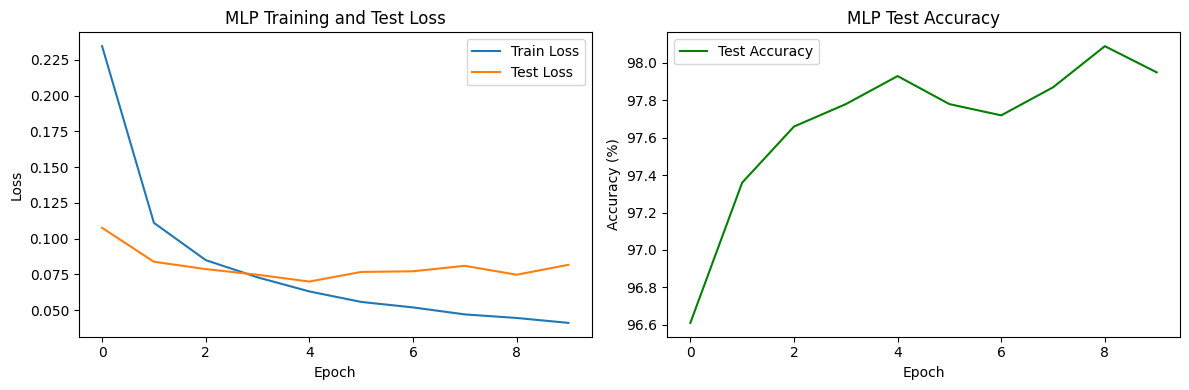


Final MLP Test Accuracy: 97.95%


In [ ]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label='Train Loss')
plt.plot(mlp_test_losses, label='Test Loss')
plt.title('MLP Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_test_accuracies, label='Test Accuracy', color='green')
plt.title('MLP Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

final_test_loss, final_test_acc = evaluate(mlp_model, mlp_criterion, test_loader)
print(f"\nFinal MLP Test Accuracy: {final_test_acc:.2f}%")


🔹 7. CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

cnn_model = CNN().to(device)
print("CNN Model Architecture:")
print(cnn_model)


CNN Model Architecture:
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)


🔹 8. CNN Loss, Optimizer, and Training

In [ ]:
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

def train_cnn(model, optimizer, criterion, train_loader, test_loader, epochs=10):
    train_losses, test_losses, test_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        test_loss, test_acc = evaluate(model, criterion, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")

    return train_losses, test_losses, test_accuracies

# Train CNN
print("\nTraining CNN...")
cnn_train_losses, cnn_test_losses, cnn_test_accuracies = train_cnn(
    cnn_model, cnn_optimizer, cnn_criterion, train_loader, test_loader, epochs=10
)



Training CNN...
Epoch [1/10] Train Loss: 0.1756, Test Loss: 0.0453, Accuracy: 98.50%
Epoch [2/10] Train Loss: 0.0600, Test Loss: 0.0302, Accuracy: 98.92%
Epoch [3/10] Train Loss: 0.0446, Test Loss: 0.0298, Accuracy: 99.01%
Epoch [4/10] Train Loss: 0.0350, Test Loss: 0.0261, Accuracy: 99.19%
Epoch [5/10] Train Loss: 0.0284, Test Loss: 0.0288, Accuracy: 99.08%
Epoch [6/10] Train Loss: 0.0252, Test Loss: 0.0244, Accuracy: 99.17%
Epoch [7/10] Train Loss: 0.0197, Test Loss: 0.0354, Accuracy: 98.94%
Epoch [8/10] Train Loss: 0.0179, Test Loss: 0.0324, Accuracy: 99.08%
Epoch [9/10] Train Loss: 0.0147, Test Loss: 0.0311, Accuracy: 99.19%
Epoch [10/10] Train Loss: 0.0149, Test Loss: 0.0267, Accuracy: 99.27%


🔹 9. Plot CNN Results

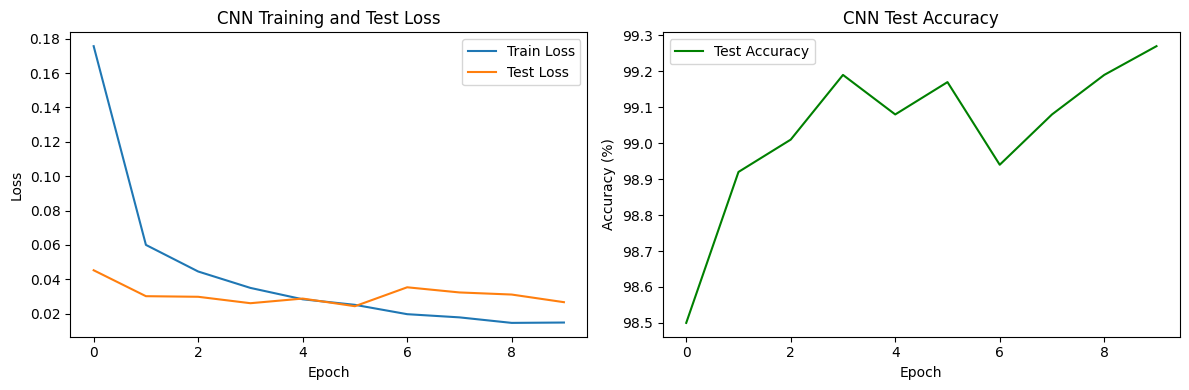


Final CNN Test Accuracy: 99.27%


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_train_losses, label='Train Loss')
plt.plot(cnn_test_losses, label='Test Loss')
plt.title('CNN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_test_accuracies, label='Test Accuracy', color='green')
plt.title('CNN Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

final_test_loss, final_test_acc = evaluate(cnn_model, cnn_criterion, test_loader)
print(f"\nFinal CNN Test Accuracy: {final_test_acc:.2f}%")


🔹 10. MLP vs CNN Comparison

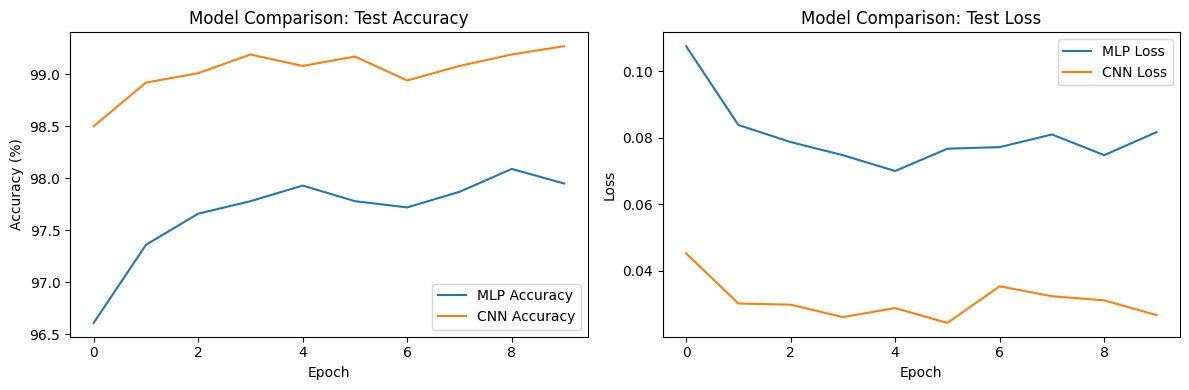

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(mlp_test_accuracies, label='MLP Accuracy')
plt.plot(cnn_test_accuracies, label='CNN Accuracy')
plt.title('Model Comparison: Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_test_losses, label='MLP Loss')
plt.plot(cnn_test_losses, label='CNN Loss')
plt.title('Model Comparison: Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
